## Dataset Loading


In [4]:
!pip install py2neo pandas matplotlib sklearn IPython

In [5]:
from py2neo import Graph
import pandas as pd
from IPython import display

graph = Graph("bolt://localhost:7687", auth=("neo4j", "123"))

#### Make sure these 4 files are moved into the Neo4j Folder 
(steps please revert to the SOP)

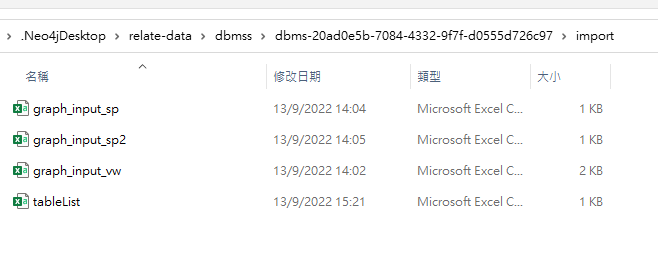

In [3]:
display.Image("PICTURE/A6_1.png")

## Create Constraints

In [3]:
#This line will replace the DROP the existing database, use with care

display(graph.run("CREATE OR REPLACE DATABASE neo4j").stats())

{'system_updates': 2}

In [4]:
display(graph.run("CREATE CONSTRAINT ON (s:SP) ASSERT s.SP_ID is unique").stats())
display(graph.run("CREATE CONSTRAINT ON (t:TABLE) ASSERT t.TABLE_ID is unique").stats())
display(graph.run("CREATE CONSTRAINT ON (v:VIEW) ASSERT v.VW_ID is unique").stats())

{'constraints_added': 1}

{'constraints_added': 1}

{'constraints_added': 1}

## Loading the data


In [5]:
query = """
//Loading the SP Node
CALL apoc.periodic.iterate(
    "CALL apoc.load.csv('file:///graph_input_sp.csv') YIELD map AS row RETURN row",
    "WITH 
        row.SP_NAME AS SP_NAME,
        row.SP_SCHEMA AS SP_SCHEMA,
        row.SP_TYPE AS SP_TYPE,
        row.SP_INDEX AS SP_INDEX,
        COALESCE(row.SP_SCHEMA ,'') + '.' + COALESCE(row.SP_NAME ,'') AS SP_ID,
        row.EXCLUSION AS EXCLUSION,
    //    row.SYNTAX as SYNTAX,
        toInteger(row.SYNTAX_WORDCOUNT) as SYNTAX_WORDCOUNT

    MERGE (s:SP {SP_ID : SP_ID})
    ON CREATE SET 
        s.SP_NAME = SP_NAME,
        s.SP_SCHEMA = SP_SCHEMA,
        s.SP_TYPE = SP_TYPE,
        s.SP_INDEX = SP_INDEX,
        s.EXCLUSION = EXCLUSION,
    //    s.SYNTAX = SYNTAX,
        s.SYNTAX_WORDCOUNT = SYNTAX_WORDCOUNT
        ",
    {batchSize: 500}
);


"""
graph.run(query).to_data_frame()


,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,1,6,0,6,0,0,0,{},"{'total': 1, 'committed': 1, 'failed': 0, 'err...","{'total': 6, 'committed': 6, 'failed': 0, 'err...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 2, 'relatio..."


In [6]:
query = """
//Loading the Table Node (Using Table Master File)
CALL apoc.periodic.iterate(
    "CALL apoc.load.csv('file:///tableList.csv') YIELD map AS row RETURN row",
    "WITH 
        toUpper(row.database) AS DATABASE,
        toUpper(row.schema) AS SCHEMA,
        toUpper(row.name) AS NAME,
        toUpper(row.type) AS TYPE,
        toUpper(COALESCE(row.schema ,'') + '.' + COALESCE(row.name ,'')) AS TABLE_ID

    MERGE (t:TABLE {TABLE_ID : TABLE_ID})
    ON CREATE SET 
        t.NAME  = NAME,
        t.SCHEMA = SCHEMA,
        t.TYPE = TYPE,
        t.DATABASE = DATABASE
        ",
    {batchSize: 500}
);

"""
graph.run(query).to_data_frame()


,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,1,5,0,5,0,0,0,{},"{'total': 1, 'committed': 1, 'failed': 0, 'err...","{'total': 5, 'committed': 5, 'failed': 0, 'err...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 5, 'relatio..."


In [7]:
query = """
//Loading the View Node
CALL apoc.periodic.iterate(
    "CALL apoc.load.csv('file:///graph_input_vw.csv') YIELD map AS row RETURN row",
    "WITH 
        COLLECT({
        VW_SCHEMA : row.VW_SCHEMA,
        VW_NAME : row.VW_NAME,
        VW_ID : COALESCE(row.VW_SCHEMA ,'') + '.' + COALESCE(row.VW_NAME,'') ,
      //  SYNTAX : row.SYNTAX,
        SYNTAX_WORDCOUNT : row.SYNTAX_WORDCOUNT 
        }) as COLLECTION

UNWIND COLLECTION as COLLECT
    MERGE (v:VIEW {VW_ID : COLLECT.VW_ID})
    ON CREATE SET 
        v.NAME  = COLLECT.VW_NAME,
        v.SCHEMA = COLLECT.VW_SCHEMA,
        v.TYPE = 'VIEW',
    //    v.SYNTAX = COLLECT.SYNTAX,
        v.SYNTAX_WORDCOUNT = COLLECT.SYNTAX_WORDCOUNT
        ",
    {batchSize: 500}
);

"""
graph.run(query).to_data_frame()


query = """
//Loading the VIEW-TABLE relationship

CALL apoc.periodic.iterate(
    "CALL apoc.load.csv('file:///graph_input_vw.csv') YIELD map AS row RETURN row",
    "WITH 
        COLLECT({
            VW_ID : COALESCE(row.VW_SCHEMA ,'') + '.' + COALESCE(row.VW_NAME,'') ,
            TABLE_ID : COALESCE(row.TABLE_SCHEMA ,'') + '.' + COALESCE(row.TABLE_NAME,'')
        }) as COLLECTION

UNWIND COLLECTION as COLLECT
        MATCH (v:VIEW {VW_ID : COLLECT.VW_ID})
        MATCH (t:TABLE {TABLE_ID: COLLECT.TABLE_ID})
        MERGE (v)-[k:RELY_ON]->(t)
            SET k.REGEX_TYPE = 'VIEW'
            SET k.TYPE = 'DEPENDS_ON'        
        ",
    {batchSize: 10000}
);
"""

graph.run(query).to_data_frame()




,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,1,2,0,2,0,0,0,{},"{'total': 1, 'committed': 1, 'failed': 0, 'err...","{'total': 2, 'committed': 2, 'failed': 0, 'err...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relatio..."


In [8]:
query = """
//Loading the SP-VIEW relationship


CALL apoc.periodic.iterate(
    "CALL apoc.load.csv('file:///graph_input_sp.csv') YIELD map AS row RETURN row",
    "WITH 
        COLLECT({
            SP_ID : COALESCE(row.SP_SCHEMA ,'') + '.' + COALESCE(row.SP_NAME ,'') ,
            VW_ID : row.TABLE_FULL_NAME ,
            REGEX_TYPE:  row.REGEX_TYPE
        }) as COLLECTION

UNWIND COLLECTION as COLLECT
        MATCH (p:SP {SP_ID : COLLECT.SP_ID})
        MATCH (v:VIEW {VW_ID: COLLECT.VW_ID})
        MERGE (p)-[k:RELY_ON]->(v)
            SET k.REGEX_TYPE = COLLECT.REGEX_TYPE
            SET k.TYPE = 'DEPENDS_ON'        
        ",
    {batchSize: 10000}
);
"""

graph.run(query).to_data_frame()


,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,1,6,0,6,0,0,0,{},"{'total': 1, 'committed': 1, 'failed': 0, 'err...","{'total': 6, 'committed': 6, 'failed': 0, 'err...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relatio..."


In [9]:

#Now link back the SP-View-Table relationship
query = """
MATCH (s:SP)-[k:RELY_ON]-(v:VIEW)-[k2:RELY_ON]->(t:TABLE)
WITH s, t
//point1 CREATE->MERGE
MERGE (s)-[r:RELY_ON]-(t)
    ON CREATE
         SET r.REGEX_TYPE = 'VIEW',
             r.TYPE = 'DEPENDS_ON'
"""

graph.run(query).to_data_frame()

""


In [10]:
query = """
//Loading the Table/View with SP relationship (DEPENDS_ON)
CALL apoc.periodic.iterate(
    "CALL apoc.load.csv('file:///graph_input_sp.csv') YIELD map AS row RETURN row",
    "WITH 
        COLLECT({
            SP_ID : COALESCE(row.SP_SCHEMA ,'') + '.' + COALESCE(row.SP_NAME ,'') ,
            TABLE_ID : row.TABLE_FULL_NAME,
            REGEX_TYPE:  row.REGEX_TYPE
        }) as COLLECTION

UNWIND COLLECTION as COLLECT
CALL apoc.do.when(COLLECT.REGEX_TYPE = 'SELECT_FROM',
        'MATCH (p:SP {SP_ID : COLLECT.SP_ID})
        MATCH (t:TABLE {TABLE_ID: COLLECT.TABLE_ID})
        MERGE (p)-[k:SP_SELECT_FROM]->(t)',
            '', {COLLECT:COLLECT}) YIELD value AS case1

WITH COLLECT
CALL apoc.do.when(COLLECT.REGEX_TYPE = 'INSERT_UPDATE',
        'MATCH (p:SP {SP_ID : COLLECT.SP_ID})
        MATCH (t:TABLE {TABLE_ID: COLLECT.TABLE_ID})
        MERGE (p)-[k:SP_INSERT_UPDATE]->(t)',
            '', {COLLECT:COLLECT}) YIELD value AS case2

    Return *
        ",
    {batchSize: 10000}
);

"""

graph.run(query).to_data_frame()


,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,1,6,0,6,0,0,0,{},"{'total': 1, 'committed': 1, 'failed': 0, 'err...","{'total': 6, 'committed': 6, 'failed': 0, 'err...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relatio..."


In [11]:
query = """
//Loading the SP-SP relationship
CALL apoc.periodic.iterate(
    "CALL apoc.load.csv('file:///graph_input_sp.csv') YIELD map AS row RETURN row",
    "WITH 
        COLLECT({
            SP_ID: COALESCE(row.SP_SCHEMA ,'') + '.' + COALESCE(row.SP_NAME,''),
            TABLE_ID: row.TABLE_FULL_NAME,
            REGEX_TYPE:  row.REGEX_TYPE
        }) as COLLECTION

UNWIND COLLECTION as COLLECT

        MATCH (s1:SP {SP_ID : COLLECT.SP_ID})
        MATCH (s2:SP {SP_ID: COLLECT.SP_ID})

        with s1, s2, COLLECT
        CALL apoc.do.when(COLLECT.REGEX_TYPE = 'EXEC',
            'MERGE (s1)-[k:CALL_SP]->(s2)',
            '', {s1:s1, s2:s2}) YIELD value AS case1
            
            RETURN count(*)
        ",
    {batchSize: 10000}
);

"""

graph.run(query).to_data_frame()

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,1,6,0,6,0,0,0,{},"{'total': 1, 'committed': 1, 'failed': 0, 'err...","{'total': 6, 'committed': 6, 'failed': 0, 'err...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relatio..."


### Data Manipulation
- Utility Tables are excluded 
- Summary Tables are excluded

In [12]:
#The AUDIT table is excluded from the calculation
exploratory_query = """
MATCH (t:TABLE)
where t.TABLE_ID = 'PREPARE.AUDIT_INGESTION_SUMMARY' or t.TABLE_ID contains 'UTIL.'
SET t.EXCLUSION = 1
"""

graph.run(exploratory_query).to_data_frame()

exploratory_query = """
MATCH (t:TABLE)
where t.EXCLUSION is null
SET t.EXCLUSION = 0
"""
graph.run(exploratory_query).to_data_frame()

exploratory_query = """
MATCH (s:SP)
where s.EXCLUSION = 'True'
SET s.EXCLUSION = 1
"""
graph.run(exploratory_query).to_data_frame()

exploratory_query = """
MATCH (s:SP)
where s.EXCLUSION = 'False'
SET s.EXCLUSION = 0
"""

graph.run(exploratory_query).to_data_frame()

""


#### We will fill up direct/indirect linked SP-Table relationships with a generic "RELY_ON"

In [13]:
#If a SP calls another SP, Then the SP should have the RELY_ON relationship for the called SP as well
query = """
    MATCH (s:SP)-[:SP_INSERT_UPDATE|SP_SELECT_FROM]->(t:TABLE)
        WITH 
            s, t
        
        MERGE(s)-[k:RELY_ON]->(t)
            
"""

graph.run(query).to_data_frame()

""


In [14]:
#If a SP calls another SP, Then the SP should have the RELY_ON relationship for the called SP as well
query = """
    MATCH (s:SP)-[:CALL_SP]->(s2:SP)-[:RELY_ON]->(t:TABLE)
        WITH 
            s, t
        
        MERGE(s)-[k:RELY_ON]->(t)
            SET k.REGEX_TYPE = 'SP_CALL_SP'
            SET k.TYPE = 'DEPENDS_ON'
            
"""

graph.run(query).to_data_frame()

""


In [15]:

display(graph.run("CREATE INDEX ON :TABLE(SKIP_FLAG)").stats())
display(graph.run("CREATE INDEX ON :SP(wcc_group)").stats())

{'indexes_added': 1}

{'indexes_added': 1}

## To check the schema within our database:

In [16]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [Node('TABLE', constraints=["Constraint( id=6, name='constraint_8509ffa1', type='UNIQUENESS', schema=(:TABLE {TABLE_ID}), ownedIndex=5 )"], indexes=['SKIP_FLAG'], name='TABLE'),
   Node('SP', constraints=["Constraint( id=4, name='constraint_bbc1861', type='UNIQUENESS', schema=(:SP {SP_ID}), ownedIndex=3 )"], indexes=['wcc_group'], name='SP'),
   Node('VIEW', constraints=["Constraint( id=8, name='constraint_a05c4504', type='UNIQUENESS', schema=(:VIEW {VW_ID}), ownedIndex=7 )"], indexes=[], name='VIEW')],
  'relationships': [SP_SELECT_FROM(Node(), Node()),
   SP_INSERT_UPDATE(Node(), Node()),
   RELY_ON(Node(), Node()),
   RELY_ON(Node(), Node())]}]

The nodes we have:

In [17]:
print("Nodes:")

result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

Nodes:


,label,count
0,SP,2
2,VIEW,2
1,TABLE,5


The relationships we have:

In [18]:
print("Relationships:")

result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

Relationships:


,relType,count
2,SP_SELECT_FROM,2
1,SP_INSERT_UPDATE,4
0,RELY_ON,8


In [6]:
display.Image("PICTURE/A6_2.png")

AttributeError: 'function' object has no attribute 'Image'

### Export Lineage data into Excel
- Moving between layers within Synapse
- Prepare -> Analyse -> Publish


In [28]:
query = """
match r1=(t1:TABLE)-[:RELY_ON]-(s1:SP)-[:RELY_ON]-(t2:TABLE)-[:RELY_ON]-(s2:SP)-[:RELY_ON]-(t3:TABLE)
where t1.SCHEMA ='PREPARE' and t2.SCHEMA ='ANALYSE' and t3.SCHEMA ='PUBLISH'
return t1.TABLE_ID, s1.SP_ID, t2.TABLE_ID, s2.SP_ID, t3.TABLE_ID
"""

df = graph.run(query).to_data_frame()
df

df = df.drop_duplicates()
df.to_excel("lineage_excel.xlsx")